In [1]:
import os
import yaml
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
from rtree import index
import glob
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transformsnormalized_price




In [2]:
# --------------------------
# Implement the model
# --------------------------

# GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Regression Model (for predicting normalized prices between 0 and 1)
class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name='efficientnet_b3'):
        super(EfficientNetRegressor, self).__init__()
        
        self.backbone = timm.create_model(model_name, 
                                         pretrained=True,
                                         num_classes=0,
                                         global_pool='avg')
        
        # Single output neuron for regression (price prediction)
        self.regressor = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features)

# Put model on GPU
model = EfficientNetRegressor(model_name='efficientnet_b3')
model = model.to(device)

print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"Model is on: {next(model.parameters()).device}")

Using device: cpu


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

GPU available: False
GPU name: None
Model is on: cpu


In [3]:
# --------------------------
# Load the trained model
# --------------------------
model = EfficientNetRegressor()
model.load_state_dict(torch.load("/kaggle/input/best-regression-model-berlin/best_regression_model_berlin.pth", map_location="cpu"))
# model.load_state_dict(torch.load("/kaggle/input/regression-model-weights/best_regression_model_2.pth", map_location="cuda"))
model.eval()

# pick the last convolutional layer of EfficientNet_B3
# (for EfficientNet, good choice is the last "features" block)
target_layer = model.backbone.conv_head 

In [4]:
# --------------------------
# Forward & backward hooks
# --------------------------
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations["value"] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0].detach()
'''
fwd_handle = target_layer.register_forward_hook(forward_hook)
bwd_handle = target_layer.register_full_backward_hook(backward_hook)
'''

'\nfwd_handle = target_layer.register_forward_hook(forward_hook)\nbwd_handle = target_layer.register_full_backward_hook(backward_hook)\n'

In [5]:
'''
# --------------------------
# Load and preprocess an image
# --------------------------
filenames = pd.read_csv("CAM_images_paths.txt", header=None, names=["filenames"])

def image_preprocess(img_path):

# img_path = '/kaggle/input/geovaluatorberlin/images/Charlottenburg/52.50023683667475,13.328727496911089.jpg'
img_path = '/kaggle/input/geovaluatorberlin/images/Kreuzberg/52.4886583895361,13.40768900325873.jpg'
img_pil = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((300, 300)),   # EfficientNet_B3 expects 300x300
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

x = preprocess(img_pil).unsqueeze(0)  # (1,3,300,300)
'''

'\n# --------------------------\n# Load and preprocess an image\n# --------------------------\nfilenames = pd.read_csv("CAM_images_paths.txt", header=None, names=["filenames"])\n\ndef image_preprocess(img_path):\n\n# img_path = \'/kaggle/input/geovaluatorberlin/images/Charlottenburg/52.50023683667475,13.328727496911089.jpg\'\nimg_path = \'/kaggle/input/geovaluatorberlin/images/Kreuzberg/52.4886583895361,13.40768900325873.jpg\'\nimg_pil = Image.open(img_path).convert("RGB")\n\npreprocess = transforms.Compose([\n    transforms.Resize((300, 300)),   # EfficientNet_B3 expects 300x300\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                         std=[0.229, 0.224, 0.225]),\n])\n\nx = preprocess(img_pil).unsqueeze(0)  # (1,3,300,300)\n'

In [5]:
imgs = []
X = []

def image_preprocess(img_path):
    # opens images and preprocesses them
    # imgs: contains the original images
    # X: contains the preprocessed images
    img_paths = '/kaggle/input/geovaluatorberlin/images/'+img_path
    img_pil = Image.open(img_paths).convert("RGB")
    imgs.append(img_pil)
    preprocess = transforms.Compose([
        transforms.Resize((300, 300)),   # EfficientNet_B3 expects 300x300
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    x = preprocess(img_pil).unsqueeze(0)  # (1,3,300,300)
    X.append(x)

# open file with image paths
with open("/kaggle/input/cam-image-paths/CAM_images_paths.txt") as f:
    filenames = f.read().splitlines()

labels = pd.read_csv("/kaggle/input/cam-images-districts/CAM_images_districts.txt", header=None, names=["district", "rent"])

for ii in filenames:
    image_preprocess(ii)

In [6]:
labels["district"][0]

'Charlottenburg'

In [7]:
# --------------------------
# Forward + Backward
# --------------------------
'''
out = model(x)              # regression output
scalar = out.squeeze()      # ensure scalar
model.zero_grad()
scalar.backward()
'''

def CAM(x):
    out = model(x)              # regression output
    scalar = out.squeeze()      # ensure scalar
    model.zero_grad()
    scalar.backward()

    # compute CAM
    acts = activations["value"]   # (1,C,h,w)
    grads = gradients["value"]    # (1,C,h,w)

    weights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)
    cam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)
    cam = torch.relu(cam)
    cam = F.interpolate(cam, size=(640,640), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # normalize [0,1]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [9]:
# --------------------------
# Compute CAM
# --------------------------
'''
acts = activations["value"]   # (1,C,h,w)
grads = gradients["value"]    # (1,C,h,w)

weights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)
cam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)
cam = torch.relu(cam)
cam = F.interpolate(cam, size=(640,640), mode="bilinear", align_corners=False)
cam = cam.squeeze().cpu().numpy()

# normalize [0,1]
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
'''

'\nacts = activations["value"]   # (1,C,h,w)\ngrads = gradients["value"]    # (1,C,h,w)\n\nweights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)\ncam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)\ncam = torch.relu(cam)\ncam = F.interpolate(cam, size=(640,640), mode="bilinear", align_corners=False)\ncam = cam.squeeze().cpu().numpy()\n\n# normalize [0,1]\ncam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)\n'

In [8]:
# --------------------------
# Plot results
# --------------------------
def Plot(cam, img_pil, districts, ii):
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_pil)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM heatmap")
    plt.imshow(cam, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img_pil)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.axis("off")

    # plt.savefig('/kaggle/working/Grad-CAM_'+img_path)
    plt.savefig('/kaggle/working/GradCAM_'+districts+f'_{ii}.jpg')

    plt.show()

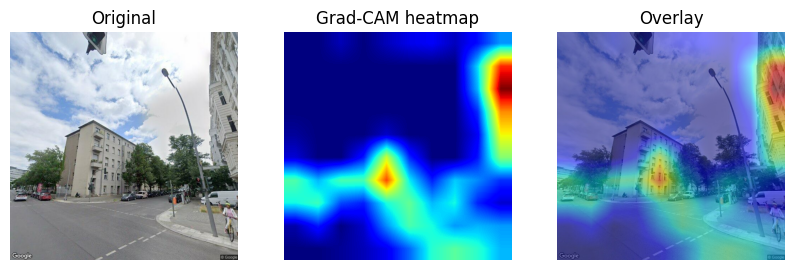

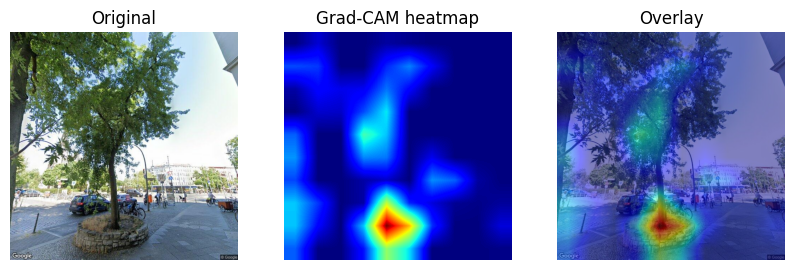

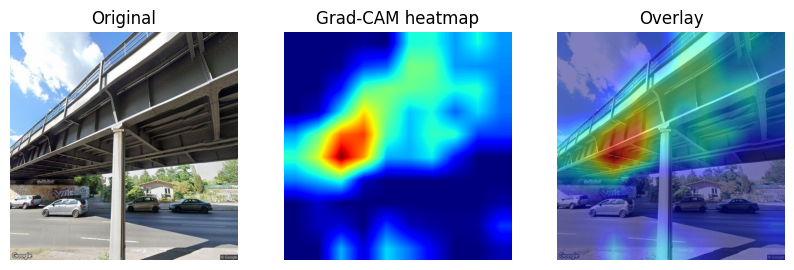

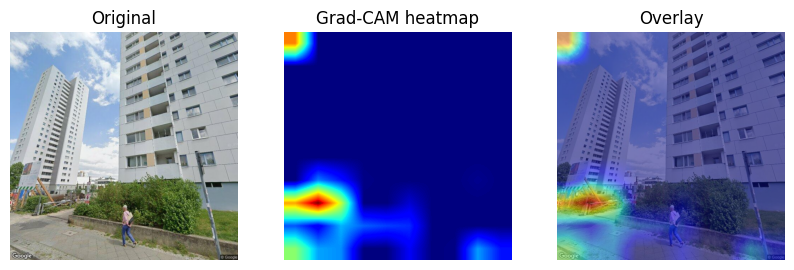

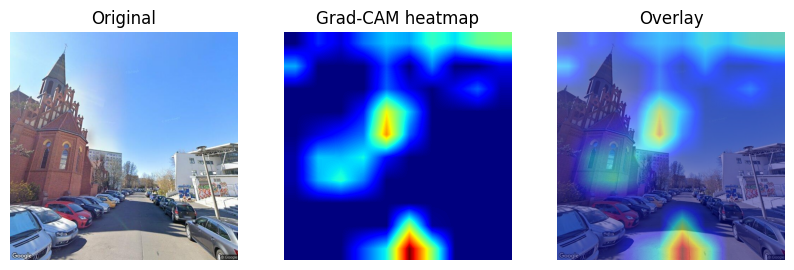

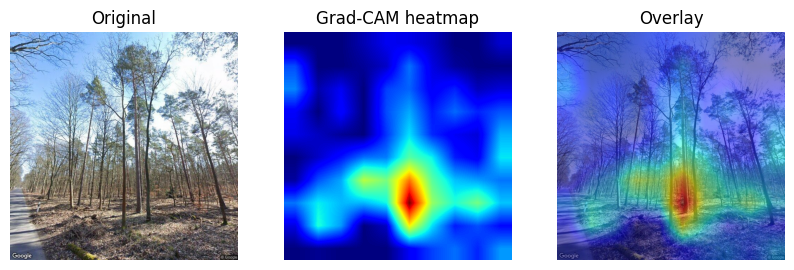

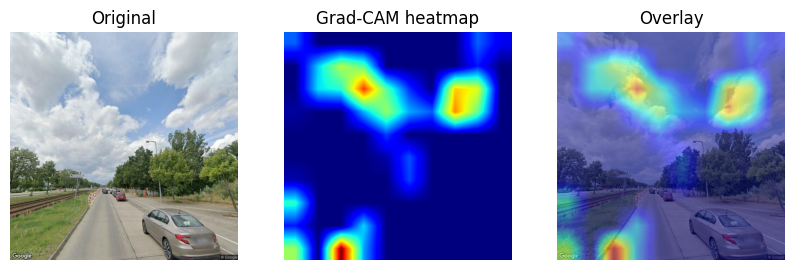

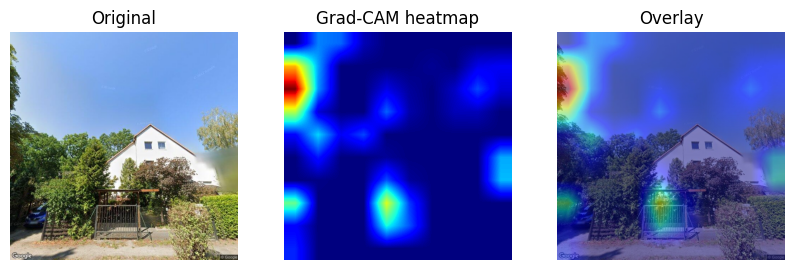

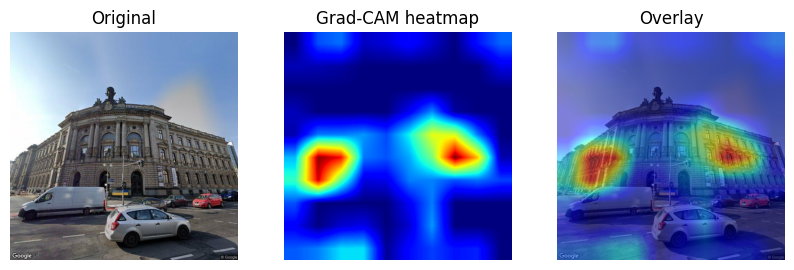

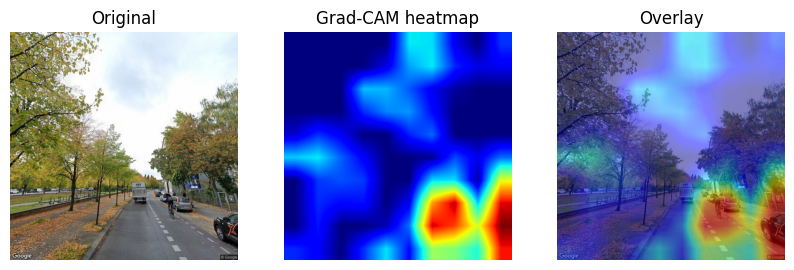

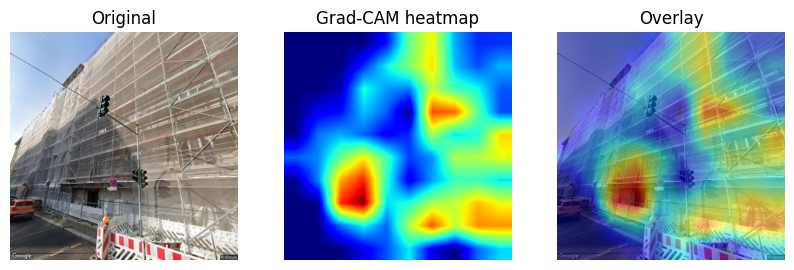

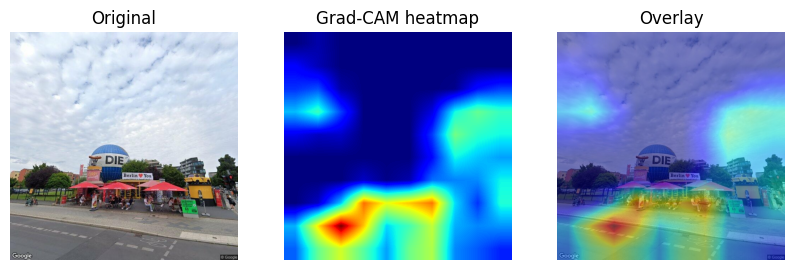

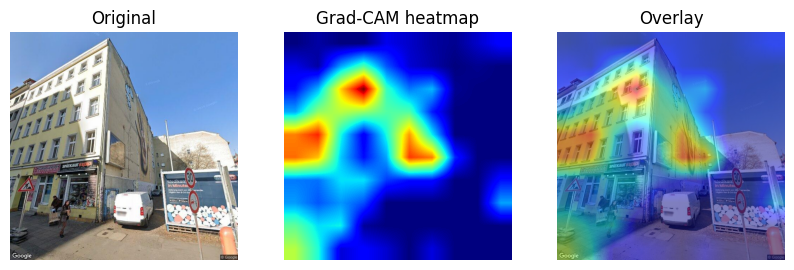

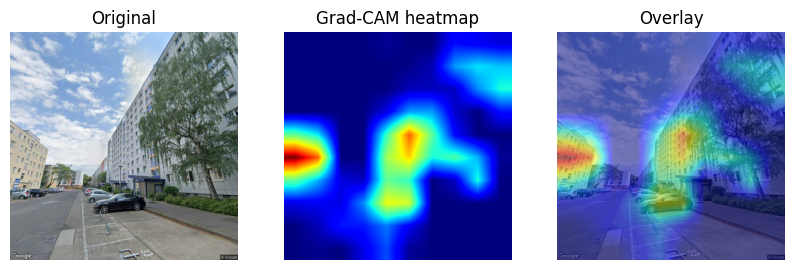

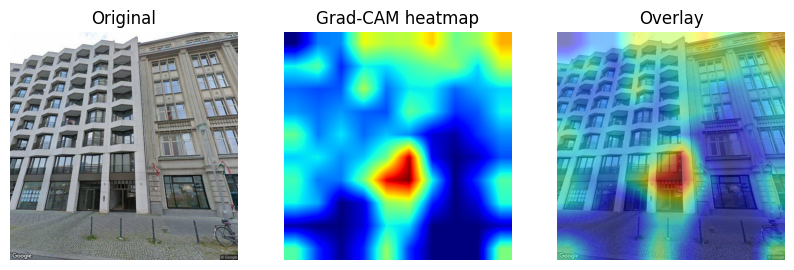

In [9]:
# --------------------------
# Iteration cell
# --------------------------
for ii in range(15):
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    cam = CAM(X[ii])
    Plot(cam, imgs[ii], labels["district"][ii], ii)

    fwd_handle.remove()
    bwd_handle.remove()

In [13]:
with open('/kaggle/input/berlin-bin-data/download_checkpoint.json', 'r') as f:
    data = json.load(f)

In [17]:
# --------------------------
# Evaluate Performance
# --------------------------
'''
scaler = MinMaxScaler()
def denormalize_price_log(normalized_price, scaler):
    """Convert normalized price back to actual rent price using inverse log+MinMax"""
    log_price = scaler.inverse_transform([[normalized_price]])[0][0]
    rent_price = np.expm1(log_price)
    return rent_price
'''

for ii in range(15):
    with torch.no_grad():
        pred = model(X[ii])
        pred_value = pred.item()   # scalar, normalized
        #pred_value_denormalized = denormalize_price_log(pred_value, scaler)   # denormalized prediction
    true_label = labels["rent"][ii]
    
    print(f"True label {ii}: {true_label}")
    print(f"Predicted {ii}: {pred_value:.4f}")
    print(f"Error {ii}: {abs(pred_value - true_label):.4f}\n")

True label 0: 19.65
Predicted 0: 0.7460
Error 0: 18.9040

True label 1: 16.13
Predicted 1: 0.5571
Error 1: 15.5729

True label 2: 14.18
Predicted 2: 0.6248
Error 2: 13.5552

True label 3: 9.67
Predicted 3: 0.1977
Error 3: 9.4723

True label 4: 13.52
Predicted 4: 0.4494
Error 4: 13.0706

True label 5: 14.49
Predicted 5: 0.5153
Error 5: 13.9747

True label 6: 13.37
Predicted 6: 0.4368
Error 6: 12.9332

True label 7: 13.09
Predicted 7: 0.4816
Error 7: 12.6084

True label 8: 22.39
Predicted 8: 0.7789
Error 8: 21.6111

True label 9: 22.39
Predicted 9: 0.6287
Error 9: 21.7613

True label 10: 22.39
Predicted 10: 0.8448
Error 10: 21.5452

True label 11: 22.39
Predicted 11: 0.6215
Error 11: 21.7685

True label 12: 22.39
Predicted 12: 0.6747
Error 12: 21.7153

True label 13: 22.39
Predicted 13: 0.7020
Error 13: 21.6880

True label 14: 22.39
Predicted 14: 0.9217
Error 14: 21.4683



In [ ]:
'''
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_pil)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM heatmap")
plt.imshow(cam, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img_pil)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")

plt.savefig('Grad-CAM_Kreuzberg.jpg')

plt.show()
'''